In [1]:
import ee
import geemap

ee.Initialize()

#### The USGS produces data in 3 tiers (categories) for each satellite:

* Tier 1 (T1) - Data that meets geometric and radiometric quality requirements
* Tier 2 (T2) - Data that doesn't meet the Tier 1 requirements
* Real Time (RT) - Data that hasn't yet been evaluated (it takes as much as a month).

| ID                         | Description                                      |
|----------------------------|--------------------------------------------------|
| LANDSAT/LC08/C01/T1_RT_TOA | Landsat 8, Collection 1, Tier 1 + Real Time, TOA |
| LANDSAT/LC08/C01/T1_TOA    | Landsat 8, Collection 1, Tier 1 only, TOA        |
| LANDSAT/LC08/C01/T1_SR     | Landsat 8, Collection 1, Tier 1 only, SR         |
| LANDSAT/LC08/C01/T2_TOA    | Landsat 8, Collection 1, Tier 2 only, TOA        |
| LANDSAT/LC08/C01/T2_SR     | Landsat 8, Collection 1, Tier 2 only, SR         |

Newly acquired scenes are added to the T1_RT collection daily. Once an RT scene gets reprocessed and categorized as either T1 or T2, it will be removed from the T1_RT collection and the new version will be added to the appropriate collection(s). If your work is sensitive to removals or potentially mis-registered scenes, you might want to stick to the T1 collection, but in general, it's very uncommon that any misregistration is large enough to notice on newly acquired scenes.

### Sentinel-2

* Sentinel-2 is a wide-swath, high-resolution, multi-spectral imaging mission supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas.


* The Sentinel-2 data contain 13 UINT16 spectral bands representing TOA reflectance scaled by 10000.


* The Sentinel-2 L2 data are downloaded from scihub. They were computed by running sen2cor. 


* Each Sentinel-2 product (zip archive) may contain multiple granules. Each granule becomes a separate Earth Engine asset. EE asset ids for Sentinel-2 assets have the following format: COPERNICUS/S2/20151128T002653_20151128T102149_T56MNN. Here the first numeric part represents the sensing date and time, the second numeric part represents the product generation date and time, and the final 6-character string is a unique granule identifier indicating its UTM grid reference.


* The assets contain 12 UINT16 spectral bands representing SR scaled by 10000 (unlike in L1 data, there is no B10). There are also several more L2-specific bands. In addition, three QA bands are present where one (QA60) is a bitmask band with cloud mask information.


* ```python
ee.ImageCollection("COPERNICUS/S2")
```

* ```python
ee.ImageCollection("COPERNICUS/S2_SR")
```
Bands estandar:
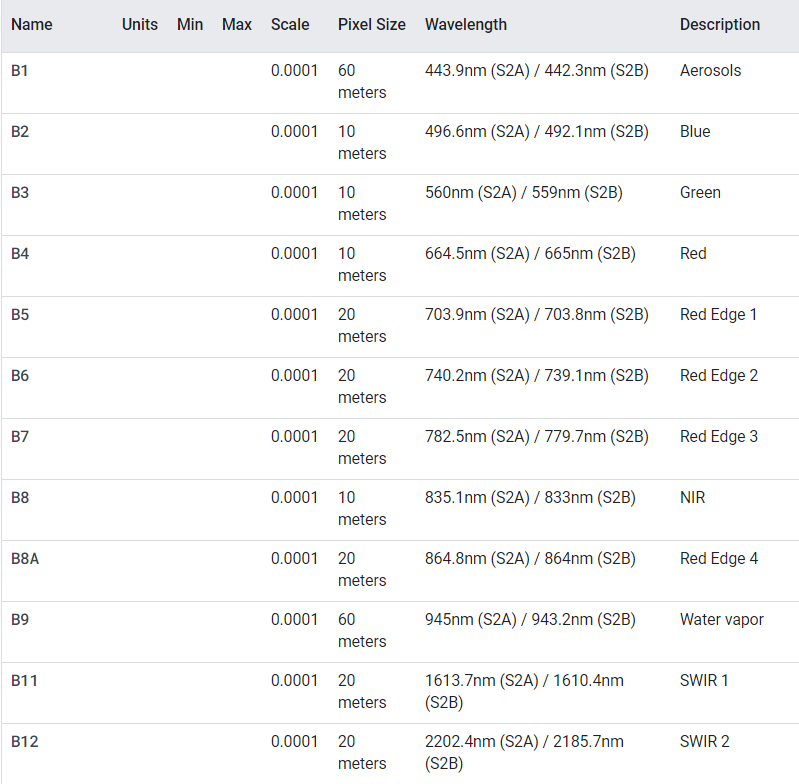

### Sentinel-3 OLCI

* The Ocean and Land Color Instrument (OLCI) Earth Observation Full Resolution (EFR) dataset contains top of atmosphere radiances at 21 spectral bands with center wavelengths ranging between 0.4μm and 1.02μm at spatial resolution of 300m with worldwide coverage every ~2 days.


* OLCI is one of the instruments in the ESA/EUMETSAT Sentinel-3 mission for measuring sea-surface topography, sea- and land-surface temperature, ocean color and land color with high-end accuracy and reliability to support ocean forecasting systems, as well as environmental and climate monitoring.


* The Sentinel-3 OLCI instrument is based on the optomechanical and imaging design of ENVISAT's MERIS. It is designed to retrieve the spectral distribution of upwelling radiance just above the sea surface (the water-leaving radiance).


* ```python
ee.ImageCollection("COPERNICUS/S3/OLCI")
```

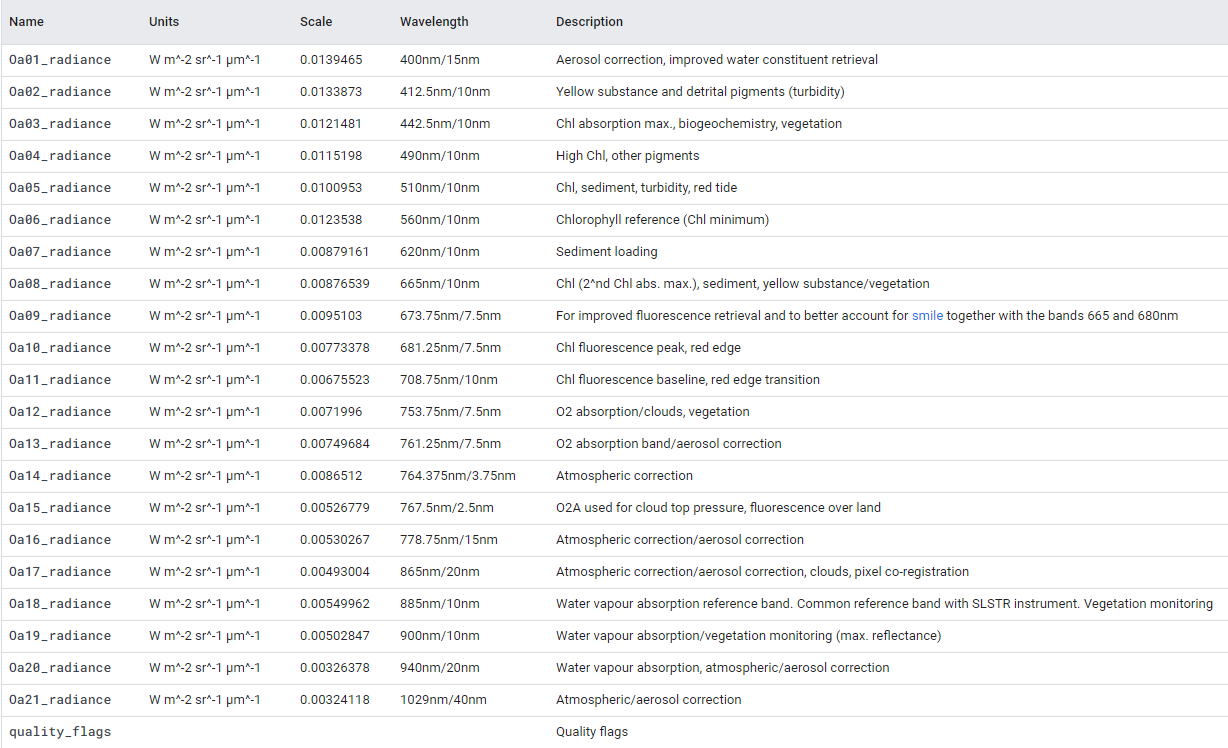

### Definir parametros de laguna

In [2]:
# [lat, lon]
sauce_center = [-34.83326008, -55.05417706]
center_point = ee.Geometry.Point(sauce_center[1], sauce_center[0])
# [[lon, lat]]
sauce_zone = [[-55.16629529644229, -34.7494869239046],
              [-55.02038312603214, -34.7494869239046],
              [-55.02038312603214, -34.868725532230165],
              [-55.16629529644229, -34.868725532230165],
              [-55.16629529644229, -34.7494869239046]]
sauce_geometry = ee.Geometry.Polygon(sauce_zone)
#Dates to filter
start = ee.Date('2019-12-21')
finish = ee.Date('2020-03-21')
# RGB bands
RGB = ['B4', 'B3', 'B2']

### Crear mapa interactivo
Additional basemaps can be added using the Map.setOptions() function. The optional basemaps can be ROADMAP, SATELLITE, HYBRID, TERRAIN, or ESRI.

In [24]:
Map_landsat = geemap.Map(center=sauce_center, zoom=11)
Map_S2 = geemap.Map(center=sauce_center, zoom=11)
Map_S3 = geemap.Map(center=sauce_center, zoom=11)

## Finding images, image collections and feature collections
Images, image collections, and feature collections are discoverable by searching the Earth Engine Data Catalog. For example, entering ‘Landsat 8’ into the search field results in a list of raster datasets. (The complete listing of Earth Engine datasets is at the [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets)). Click on the dataset name to get a brief description, information about the temporal availability, data provider and collection ID. 

In [25]:

# filter satellite collection by date, bounds and sort by cloud cover
filteredCollection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(sauce_geometry) \
    .filterDate(start, finish) \
    .sort('CLOUD_COVER', True)

count = filteredCollection.size()
print('Count: ', str(count.getInfo())+'\n')

# Makes image in which every pixel is the median of that position in every image from the collection
image = filteredCollection.reduce('median')
# Resolution in meters to compute the percentile at
PERCENTILE_SCALE = 30  
# Apply a reducer to all the pixels in a specific region. Gets minimum and maximum median value for every band.
percentiles = image.reduceRegion(ee.Reducer.percentile([0, 100], ['min', 'max']),
                                 sauce_geometry, PERCENTILE_SCALE).getInfo()
print(percentiles)

# Extracting the results
minVals = [percentiles["B4_median_min"], percentiles["B3_median_min"], percentiles["B2_median_min"]]
print(minVals)
maxVals = [percentiles["B4_median_max"], percentiles["B3_median_max"], percentiles["B2_median_max"]]
print(maxVals)

# converts image to 8-bit RGB using the bands given
reduction = image.visualize(bands=RGB,
                            min=minVals, # reverse since bands are given in the other way (b2,b3,4b)
                            max=maxVals,
                            gamma=1)

first = filteredCollection.first()
# Define visualization parameters in an object literal.
vizParams = {'bands': RGB,
             'min': minVals, 'max': maxVals, 'gamma': 1}

Map_landsat.addLayer(first.clip(sauce_geometry), vizParams, 'Landsat 8 image')

# Diplay the map
Map_landsat.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map_landsat

Count:  11

{'B10_median_max': 3067, 'B10_median_min': 2938, 'B11_median_max': 3020, 'B11_median_min': 2921, 'B1_median_max': 3070, 'B1_median_min': 13, 'B2_median_max': 3319, 'B2_median_min': 99, 'B3_median_max': 3974, 'B3_median_min': 189, 'B4_median_max': 4286, 'B4_median_min': 131, 'B5_median_max': 5488, 'B5_median_min': 98, 'B6_median_max': 5502, 'B6_median_min': 49, 'B7_median_max': 4967, 'B7_median_min': 30, 'pixel_qa_median_max': 480, 'pixel_qa_median_min': 322, 'radsat_qa_median_max': 0, 'radsat_qa_median_min': 0, 'sr_aerosol_median_max': 224, 'sr_aerosol_median_min': 8}
[131, 189, 99]
[4286, 3974, 3319]


Map(center=[-34.83326008, -55.05417706], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [26]:
# filter satellite collection by date, bounds and sort by cloud cover

filteredCollection = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(sauce_geometry) \
    .filterDate(start, finish) \
    .sort('CLOUD_COVER', True)

count = filteredCollection.size()
print('Count: ', str(count.getInfo())+'\n')

# Makes image in which every pixel is the median of that position in every image from the collection
image = filteredCollection.reduce('median')
# Resolution in meters to compute the percentile at
PERCENTILE_SCALE = 10
# Apply a reducer to all the pixels in a specific region. Gets minimum and maximum median value for every band.
percentiles = image.reduceRegion(ee.Reducer.percentile([0, 100], ['min', 'max']),
                                 sauce_geometry, PERCENTILE_SCALE, bestEffort=True).getInfo()
print(percentiles)

# Extracting the results
minVals = [percentiles["B4_median_min"], percentiles["B3_median_min"], percentiles["B2_median_min"]]
print(minVals)
maxVals = [percentiles["B4_median_max"], percentiles["B3_median_max"], percentiles["B2_median_max"]]
print(maxVals)

# converts image to 8-bit RGB using the bands given
reduction = image.visualize(bands=RGB,
                            min=minVals, # reverse since bands are given in the other way (b2,b3,4b)
                            max=maxVals,
                            gamma=1)

first = filteredCollection.first()
# Define visualization parameters in an object literal.
vizParams = {'bands': RGB,
             'min': minVals, 'max': maxVals, 'gamma': 1}

Map_S2.addLayer(first.clip(sauce_geometry), vizParams, 'Landsat 8 image')

# Diplay the map
Map_S2.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map_S2

Count:  36

{'AOT_median_max': 141, 'AOT_median_min': 118, 'B11_median_max': 5737.5, 'B11_median_min': 95, 'B12_median_max': 5630, 'B12_median_min': 72.5, 'B1_median_max': 2647.5, 'B1_median_min': 168, 'B2_median_max': 6043, 'B2_median_min': 187.5, 'B3_median_max': 6137, 'B3_median_min': 226, 'B4_median_max': 6102.5, 'B4_median_min': 177, 'B5_median_max': 5669.5, 'B5_median_min': 232.5, 'B6_median_max': 5571, 'B6_median_min': 183.5, 'B7_median_max': 5659.5, 'B7_median_min': 211, 'B8A_median_max': 5576.5, 'B8A_median_min': 159, 'B8_median_max': 5943.5, 'B8_median_min': 185, 'B9_median_max': 5298, 'B9_median_min': 145.5, 'MSK_CLDPRB_median_max': 100, 'MSK_CLDPRB_median_min': 0, 'MSK_SNWPRB_median_max': 0, 'MSK_SNWPRB_median_min': 0, 'QA10_median_max': 0, 'QA10_median_min': 0, 'QA20_median_max': 0, 'QA20_median_min': 0, 'QA60_median_max': 0, 'QA60_median_min': 0, 'SCL_median_max': 9, 'SCL_median_min': 2, 'TCI_B_median_max': 255, 'TCI_B_median_min': 19.5, 'TCI_G_median_max': 255, 'TCI_G_me

Map(center=[-34.83326008, -55.05417706], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [33]:
RGB = ["Oa08_radiance", "Oa06_radiance", "Oa04_radiance"]
# filter satellite collection by date, bounds and sort by cloud cover

filteredCollection = ee.ImageCollection("COPERNICUS/S3/OLCI") \
    .filterBounds(sauce_geometry) \
    .filterDate(start, finish) \
    .sort('CLOUD_COVER', True)

count = filteredCollection.size()
print('Count: ', str(count.getInfo())+'\n')

# Makes image in which every pixel is the median of that position in every image from the collection
image = filteredCollection.reduce('median')
# Resolution in meters to compute the percentile at
PERCENTILE_SCALE = 300
# Apply a reducer to all the pixels in a specific region. Gets minimum and maximum median value for every band.
percentiles = image.reduceRegion(ee.Reducer.percentile([0, 100], ['min', 'max']),
                                 sauce_geometry, PERCENTILE_SCALE, bestEffort=True).getInfo()
print(percentiles)

# Extracting the results
minVals = [percentiles["Oa08_radiance_median_min"], percentiles["Oa06_radiance_median_min"], 
           percentiles["Oa04_radiance_median_min"]]
print(minVals)
maxVals = [percentiles["Oa08_radiance_median_max"], percentiles["Oa06_radiance_median_max"], 
           percentiles["Oa04_radiance_median_max"]]
print(maxVals)

# converts image to 8-bit RGB using the bands given
reduction = image.visualize(bands=RGB,
                            min=minVals, # reverse since bands are given in the other way (b2,b3,4b)
                            max=maxVals,
                            gamma=1)

first = filteredCollection.first()
# Define visualization parameters in an object literal.
vizParams = {'bands': RGB,
             'min': minVals, 'max': maxVals, 'gamma': 1}

Map_S3.addLayer(first.clip(sauce_geometry), vizParams, 'Landsat 8 image')

# Diplay the map
Map_S3.setControlVisibility(layerControl=True, fullscreenControl=True, latLngPopup=True)
Map_S3

Count:  112

{'Oa01_radiance_median_max': 97.125, 'Oa01_radiance_median_min': 86, 'Oa02_radiance_median_max': 102.66666666666667, 'Oa02_radiance_median_min': 90, 'Oa03_radiance_median_max': 99, 'Oa03_radiance_median_min': 80.4, 'Oa04_radiance_median_max': 85, 'Oa04_radiance_median_min': 62.375, 'Oa05_radiance_median_max': 79.5, 'Oa05_radiance_median_min': 56.5, 'Oa06_radiance_median_max': 72.4375, 'Oa06_radiance_median_min': 44, 'Oa07_radiance_median_max': 63.535714285714285, 'Oa07_radiance_median_min': 32, 'Oa08_radiance_median_max': 60.8, 'Oa08_radiance_median_min': 26, 'Oa09_radiance_median_max': 60, 'Oa09_radiance_median_min': 24.25, 'Oa10_radiance_median_max': 59.575, 'Oa10_radiance_median_min': 24.2, 'Oa11_radiance_median_max': 74.6, 'Oa11_radiance_median_min': 22, 'Oa12_radiance_median_max': 108.5, 'Oa12_radiance_median_min': 16, 'Oa13_radiance_median_max': 30, 'Oa13_radiance_median_min': 5, 'Oa14_radiance_median_max': 53, 'Oa14_radiance_median_min': 8, 'Oa15_radiance_median_max

Map(bottom=316598.0, center=[-34.83326008, -55.05417706], controls=(WidgetControl(options=['position'], widget…